In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import h5py, os
from mpl_toolkits import mplot3d
from imp import reload
from scipy.interpolate import interp1d
import matplotlib.cm as cm

from scipy.signal import resample

from cca import ComplexityComponentsAnalysis
import cca
from cca.cov_util import calc_cross_cov_mats_from_data, calc_pi_from_cross_cov_mats
from cca.synth_data import embedded_lorenz_cross_cov_mats, gen_lorenz_data, random_basis
from cca.data_util import form_lag_matrix
from cca.cca import pi_fft
from cca import style

#from info_measures.continuous import kraskov_stoegbauer_grassberger as ksg

In [2]:
#Analysis functions

def gen_pi_heatmap(calc_pi_fn, N=100):
    theta_vals = np.linspace(0, np.pi, N)
    phi_vals = np.linspace(0, np.pi, N)
    heatmap = np.zeros((N, N))
    for theta_idx in range(N):
        if theta_idx % 10 == 0:
            print("theta_idx =", theta_idx)
        for phi_idx in range(N):
            theta, phi = theta_vals[theta_idx], phi_vals[phi_idx]
            x = np.cos(phi)*np.sin(theta)
            y = np.sin(phi)*np.sin(theta)
            z = np.cos(theta)
            V = np.array([x, y, z]).reshape((3, 1))
            heatmap[theta_idx, phi_idx] = calc_pi_fn(V)
    return heatmap

def make_pi_fn_gp(cross_cov_mats):
    def calc_pi_fn_gp(V):
        pi = calc_pi_from_cross_cov_mats(cross_cov_mats, proj=V)
        return pi
    return calc_pi_fn_gp

def make_pi_fn_knn(X, T_pi):
    def calc_pi_fn_knn(V):
        X_proj = np.dot(X, V)
        X_proj_lags = form_lag_matrix(X_proj, 2*T_pi)
        mi = ksg.MutualInformation(X_proj_lags[:, :T_pi], X_proj_lags[:, T_pi:], add_noise=True)
        pi = mi.mutual_information(n_jobs=4)
        return pi
    return calc_pi_fn_knn

def random_proj_pi_comparison(calc_pi_fn_1, cal_pi_fn_2, N, d=1, n_samples=10000):
    pi_1, pi_2 = np.zeros(n_samples), np.zeros(n_samples)
    for i in range(n_samples):
        if i % 50 == 0:
            print("sample =", i)
        V = random_basis(N, d)
        pi_1[i] = calc_pi_fn_1(V)
        pi_2[i] = cal_pi_fn_2(V)
    pi_12 = np.vstack((pi_1, pi_2)).T # (n_samples, 2)
    return pi_12

def gp_knn_trajectories(num_traj, cross_cov_mats, X, T_pi, d):
    opt = ComplexityComponentsAnalysis()
    f_gp = make_pi_fn_gp(cross_cov_mats)
    f_knn = make_pi_fn_knn(X, T_pi=T_pi)
    trajectories = []
    for traj_idx in range(num_traj):
        print("traj_idx =", traj_idx)
        opt = ComplexityComponentsAnalysis(init="random_ortho")
        opt.cross_covs = cross_cov_mats
        opt._fit_projection(d=d, record_V=True)
        V_seq = opt.V_seq
        num_dca_iter = len(V_seq)
        pi_gp_knn_traj = np.zeros((num_dca_iter, 2))
        for i in range(num_dca_iter):
            if i % 50 == 0:
                print(i, "of", num_dca_iter)
            V = V_seq[i]
            pi_gp_knn_traj[i, 0] = f_gp(V)
            pi_gp_knn_traj[i, 1] = f_knn(V)
        trajectories.append(pi_gp_knn_traj)
    return trajectories

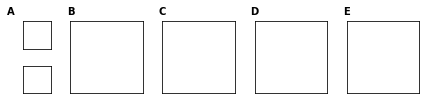

In [34]:
#Plotting functions

def make_axes(fig_width, wpad_edge=0, wpad_mid=0.05, hpad_top=0.05, hpad_bottom=0.05, small_sq_width=0.07):
    sq_width = (1. - 2*wpad_edge - small_sq_width - 4*wpad_mid) / 4.
    sq_height = 1. - hpad_top - hpad_bottom
    fig_height = sq_width * fig_width / sq_height
    small_sq_height = small_sq_width * fig_width / fig_height
    fig = plt.figure(figsize=(fig_width, fig_height))
    #2 small squares
    ax2 = fig.add_axes((wpad_edge, hpad_bottom, small_sq_width, small_sq_height))
    ax1 = fig.add_axes((wpad_edge, 1. - hpad_top - small_sq_height, small_sq_width, small_sq_height))
    #3 big squares
    ax3 = fig.add_axes((wpad_edge + small_sq_width + wpad_mid, hpad_bottom, sq_width, sq_height))
    ax4 = fig.add_axes((wpad_edge + small_sq_width + 2*wpad_mid + sq_width, hpad_bottom, sq_width, sq_height))
    ax5 = fig.add_axes((wpad_edge + small_sq_width + 3*wpad_mid + 2*sq_width, hpad_bottom, sq_width, sq_height))
    ax6 = fig.add_axes((wpad_edge + small_sq_width + 4*wpad_mid + 3*sq_width, hpad_bottom, sq_width, sq_height))
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        
    label_dx = -0.02
    label_dy = 0.05
    label_y = hpad_bottom + sq_height + label_dy
    fig.text(wpad_edge + label_dx, label_y,
             "A", va="bottom", ha="right", color="black",
             **style.panel_letter_fontstyle)
    fig.text(wpad_edge + small_sq_width + wpad_mid, label_y,
             "B", va="bottom", ha="center", color="black",
             **style.panel_letter_fontstyle)
    fig.text(wpad_edge + small_sq_width + 2*wpad_mid + sq_width, label_y,
             "C", va="bottom", ha="center", color="black",
             **style.panel_letter_fontstyle)
    fig.text(wpad_edge + small_sq_width + 3*wpad_mid + 2*sq_width, label_y,
             "D", va="bottom", ha="center", color="black",
             **style.panel_letter_fontstyle)
    fig.text(wpad_edge + small_sq_width + 4*wpad_mid + 3*sq_width, label_y,
             "E", va="bottom", ha="center", color="black",
             **style.panel_letter_fontstyle)
    return axes
    
def disp_heatmap(ax, heatmap, show_xlabels=True, show_ylabels=True, title=None):
    N_theta, N_phi = heatmap.shape
    im = ax.imshow(heatmap, origin="lower left", cmap="gray", aspect="equal")
    if show_xlabels:
        ax.set_xlabel("$\phi$", fontsize=style.axis_label_fontsize, labelpad=-8.5)
        ax.set_xticks([0, N_phi-1])
        ax.set_xticklabels(["0", "$\pi$"], fontsize=style.ticklabel_fontsize)
    else:
        ax.set_xticks([])
    if show_ylabels:
        ax.set_ylabel("$\\theta$", fontsize=style.axis_label_fontsize, labelpad=-8.5)
        ax.set_yticks([0, N_theta-1])
        ax.set_yticklabels(["0", "$\pi$"], fontsize=style.ticklabel_fontsize)
    else:
        ax.set_yticks([])
    ax.set_xlim([0, heatmap.shape[1]-1])
    ax.set_ylim([0, heatmap.shape[0]-1])
    if title is not None:
        ax.set_title(title, fontsize=style.axis_label_fontsize*0.8, pad=1)
        
def cycle_from_style(scheme):
    return [color_dict["color"] for color_dict in plt.style.library[scheme]['axes.prop_cycle']]

def disp_scatter(ax, pi_gp, pi_knn, trajectories=None, diag_text=False, arrow=True, xlabel="full PI", ylabel="Gaussian PI"):
    #Note that gp=y and knn=x, but 0 index is gp and 1 is knn in data arrays!
    traj_color = "#C63F3A"
    all_gp_vals = [pi_gp]
    all_knn_vals = [pi_knn]
    if trajectories is not None:
        all_gp_vals += [traj[:, 0] for traj in trajectories]
        all_knn_vals += [traj[:, 1] for traj in trajectories]
    all_gp_vals = np.concatenate(all_gp_vals)
    all_knn_vals = np.concatenate(all_knn_vals)
    min_gp, max_gp = all_gp_vals.min(), all_gp_vals.max()
    range_gp = max_gp - min_gp
    min_knn, max_knn = all_knn_vals.min(), all_knn_vals.max()
    range_knn = max_knn - min_knn
    pi_gp_norm = (pi_gp - min_gp)/range_gp
    pi_knn_norm = (pi_knn - min_knn)/range_knn
    ax.hexbin(pi_knn_norm, pi_gp_norm, gridsize=50, extent=(0, 1, 0, 1), cmap="gray_r", bins="log", linewidth=0.05)    
    if trajectories is not None:
        for traj_idx in range(len(trajectories)):
            traj = np.copy(trajectories[traj_idx])
            traj[:, 0] = (traj[:, 0] - min_gp)/range_gp
            traj[:, 1] = (traj[:, 1] - min_knn)/range_knn
            ax.plot(traj[:, 1], traj[:, 0], linewidth=0.5, color=traj_color)
    ax.set_xlim([0, 1.025])
    ax.set_ylim([0, 1.025])
    ax.set_xticks([0, 1])
    ax.set_xticklabels([0, 1], fontsize=style.ticklabel_fontsize)
    ax.set_yticks([0, 1])
    ax.set_yticklabels([0, 1], fontsize=style.ticklabel_fontsize)
    ax.spines['left'].set_bounds(0, 1)
    ax.spines['bottom'].set_bounds(0, 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(xlabel, fontsize=style.axis_label_fontsize, labelpad=-9.5)
    ax.set_ylabel(ylabel, fontsize=style.axis_label_fontsize, labelpad=-8)
    
    theta_deg = 47
    if diag_text:
        ax.text(0.5, 0.65, "DCA trajectories", fontsize=style.ticklabel_fontsize*0.8,
                rotation=theta_deg, rotation_mode="anchor", ha="center", va="center",
                color=traj_color)
    if arrow:
        len_x = np.cos(np.deg2rad(theta_deg))
        len_y = np.sin(np.deg2rad(theta_deg))
        mag = 0.425
        ax.quiver(0.525, 0.35, mag*len_x, mag*len_y, angles='xy', scale_units='xy', scale=1, width=0.015, color=traj_color)
    
    
    
def plot_deflation_results(ax, pi_regular, pi_def, pi_fft):
    dim_vals = np.arange(len(pi_def) + 1)
    pi_vals = (pi_regular, pi_def, pi_fft)
    labels = ["DCA", "deflation", "FFT deflation"]
    linewidth = 0.75
    colors = ["#C63F3A", "gray", "black"]
    for i in range(len(pi_vals)):
        ax.plot(dim_vals, [0] + list(pi_vals[i]), label=labels[i],
                linewidth=linewidth, color=colors[i],
                marker=".", markersize=2 if i == 1 else 1)
        
    ax.legend(fontsize=style.ticklabel_fontsize*0.8, frameon=False, labelspacing=0.1,
             bbox_to_anchor=(0.2, 0, 1, 1))
    ax.set_xlabel("dimension", fontsize=style.axis_label_fontsize, labelpad=-9.5)
    ax.set_ylabel("PI (nats)", fontsize=style.axis_label_fontsize, labelpad=-13)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    max_dim = len(pi_regular)
    max_dim_padded = max_dim * 1.025
    ax.set_xticks([0, max_dim])
    ax.set_xticklabels([0, max_dim], fontsize=style.ticklabel_fontsize)
    ax.set_xlim([0, max_dim_padded])
    ax.spines["bottom"].set_bounds(0, max_dim)
    
    max_pi = np.max(np.concatenate(pi_vals))
    max_pi_padded = max_pi * 1.025
    ax.set_yticks([0, max_pi])
    ax.set_yticklabels([0, np.round(max_pi, 1)], fontsize=style.ticklabel_fontsize)
    ax.set_ylim([0, max_pi_padded])
    ax.spines["left"].set_bounds(0, max_pi)
    
    
make_axes(5.5)

In [59]:
#Generate 3D Lorenz data and cross-cov mats
T_pi_3d = 1
num_samples_3d = 10000
X_3d = gen_lorenz_data(num_samples_3d)
cross_cov_mats_3d = calc_cross_cov_mats_from_data(X_3d, 2*T_pi_3d)

#Generate high-D Lorenz data and cross-cov mats
T_pi_hd = 1
num_samples_hd = 10000
N_hd = 30
noise_dim = 7
snr = 1.
cross_cov_mats_hd, X_hd = embedded_lorenz_cross_cov_mats(N_hd, 2*T_pi_hd, snr=snr,
                                                         noise_dim=noise_dim,
                                                         return_samples=True,
                                                         num_lorenz_samples=num_samples_hd)

KeyboardInterrupt: 

In [172]:
#Get GP and KNN PI functions for 3-D non-noisy Lorenz system
calc_pi_fn_gp_3d = make_pi_fn_gp(cross_cov_mats_3d)
calc_pi_fn_knn_3d = make_pi_fn_knn(X_3d, T_pi_3d)
#...and for high-D noisy Lorenz system
calc_pi_fn_gp_hd = make_pi_fn_gp(cross_cov_mats_hd)
calc_pi_fn_knn_hd = make_pi_fn_knn(X_hd, T_pi_hd)

#Gen heatmaps for 3-D data
n_ang = 50
heatmap_gp = gen_pi_heatmap(calc_pi_fn_gp_3d, n_ang)
heatmap_knn = gen_pi_heatmap(calc_pi_fn_knn_3d, n_ang)

#Save results
np.savez("cached_fig_data/heatmaps.npz", heatmap_knn=heatmap_knn, heatmap_gp=heatmap_gp)

theta_idx = 0
theta_idx = 10
theta_idx = 20
theta_idx = 30
theta_idx = 40
theta_idx = 0
theta_idx = 10
theta_idx = 20
theta_idx = 30
theta_idx = 40


In [ ]:
#Compare GP and KNN PI for 3-D and high-D data
n_proj = 10000
pi_gp_knn_3d = random_proj_pi_comparison(calc_pi_fn_gp_3d, calc_pi_fn_knn_3d, N=3, d=1, n_samples=n_proj)
pi_gp_knn_hd_1d = random_proj_pi_comparison(calc_pi_fn_gp_hd, calc_pi_fn_knn_hd, N=N_hd, d=1, n_samples=n_proj)
pi_gp_knn_hd_3d = random_proj_pi_comparison(calc_pi_fn_gp_hd, calc_pi_fn_knn_hd, N=N_hd, d=3, n_samples=n_proj)

#Save results
np.savez("cached_fig_data/proj_comp.npz",
         pi_gp_knn_3d=pi_gp_knn_3d,
         pi_gp_knn_hd_1d=pi_gp_knn_hd_1d,
         pi_gp_knn_hd_3d=pi_gp_knn_hd_3d)

sample = 0
sample = 50
sample = 100
sample = 150
sample = 200
sample = 250
sample = 300
sample = 350
sample = 400
sample = 450
sample = 500
sample = 550
sample = 600
sample = 650
sample = 700
sample = 750
sample = 800
sample = 850
sample = 900
sample = 950
sample = 1000
sample = 1050
sample = 1100
sample = 1150
sample = 1200
sample = 1250
sample = 1300
sample = 1350
sample = 1400
sample = 1450
sample = 1500
sample = 1550
sample = 1600
sample = 1650
sample = 1700
sample = 1750
sample = 1800
sample = 1850
sample = 1900
sample = 1950
sample = 2000
sample = 2050
sample = 2100
sample = 2150
sample = 2200
sample = 2250
sample = 2300
sample = 2350
sample = 2400
sample = 2450
sample = 2500
sample = 2550
sample = 2600
sample = 2650
sample = 2700
sample = 2750
sample = 2800
sample = 2850
sample = 2900
sample = 2950
sample = 3000
sample = 3050
sample = 3100
sample = 3150
sample = 3200
sample = 3250
sample = 3300
sample = 3350
sample = 3400
sample = 3450
sample = 3500
sample = 3550
sample = 3600
s

In [ ]:
#Get trajectories through PI plane for 1-D and 3-D projections
num_traj = 5

traj_1d = gp_knn_trajectories(num_traj, cross_cov_mats_hd, X_hd, T_pi=T_pi_hd, d=1)
traj_3d = gp_knn_trajectories(num_traj, cross_cov_mats_hd, X_hd, T_pi=T_pi_hd, d=3)

#Save results
np.savez("cached_fig_data/trajectories.npz",
         traj_1d=traj_1d,
         traj_3d=traj_3d)

['pi_def', 'pi_fft', 'pi_regular']


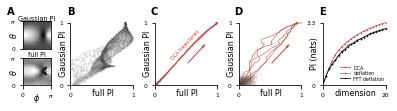

In [35]:
#Plot results

axes = make_axes(5.5, wpad_mid=0.05, hpad_bottom=0.13, hpad_top=0.16, wpad_edge=0.04)
ax1, ax2, ax3, ax4, ax5, ax6 = axes
knn_name = "full PI"
gaussian_name = "Gaussian PI"

#Plot heatmaps
d1 = np.load("cached_fig_data/heatmaps.npz")
heatmap_gp, heatmap_knn = d1["heatmap_gp"], d1["heatmap_knn"]
disp_heatmap(ax1, heatmap_gp, title=gaussian_name, show_xlabels=False, show_ylabels=True)
disp_heatmap(ax2, heatmap_knn, title=knn_name, show_xlabels=True, show_ylabels=True)

#Plot trajectories + scatters
d2 = np.load("cached_fig_data/proj_comp.npz")
pi_gp_knn_3d = d2["pi_gp_knn_3d"]
pi_gp_knn_hd_1d = d2["pi_gp_knn_hd_1d"]
pi_gp_knn_hd_3d = d2["pi_gp_knn_hd_3d"]
d3 = np.load("cached_fig_data/trajectories.npz")
traj_1d = d3["traj_1d"]
traj_3d = d3["traj_3d"]
disp_scatter(ax3, pi_gp_knn_3d[:, 0], pi_gp_knn_3d[:, 1], xlabel=knn_name, arrow=False)
disp_scatter(ax4, pi_gp_knn_hd_1d[:, 0], pi_gp_knn_hd_1d[:, 1], trajectories=traj_1d, diag_text=True, arrow=True, xlabel=knn_name, ylabel=gaussian_name)
disp_scatter(ax5, pi_gp_knn_hd_3d[:, 0], pi_gp_knn_hd_3d[:, 1], trajectories=traj_3d, arrow=True, xlabel=knn_name, ylabel=gaussian_name)

#Plot deflation stuff
d4 = np.load("cached_fig_data/def_comp.npz")
print(list(d4.keys()))
pi_regular = d4["pi_regular"]
pi_fft = d4["pi_fft"]
pi_def = d4["pi_def"]
plot_deflation_results(ax6, pi_regular, pi_def, pi_fft)

plt.savefig("figures/knn_gp.pdf")